![](images/llmcam_digitraffic.png)

In this demo, we showcase how `llmcam` simplifies the process of interacting with web services by dynamically importing API endpoints as tools for GPT Function Calling (GPT FC). Traditionally, users would need to manually navigate through various web services, search for the desired data, and interact with the service's interface - often leading to inefficiencies, errors, and delays.

With `llmcam`, users can simply issue natural language commands (e.g., "What’s the traffic situation on Route 5?"), and GPT FC automatically imports the relevant service API, performs the necessary function calls, and returns the data seamlessly. This not only streamlines the process but also allows users to combine data from different services in their workflows, making it both more efficient and flexible.

In this scenario, we’re using [Road DigiTraffic](https://www.digitraffic.fi/en/road-traffic/), an open service that provides real-time traffic data via an Open API Specification, allowing easy integration with GPT FC. `llmcam` enhances the accessibility of this service, enabling users to retrieve traffic data through simple natural language commands, bypassing the need for manual navigation. This integration also presents exciting opportunities for **smart city solutions**, where real-time traffic data can be combined with other city services — like weather, transit, and emergency response systems — creating more connected, efficient, and intelligent urban environments.

## Setting Up Dynamic Tool Imports
In this first step, we will set up the foundation for dynamic tool imports via GPT Function Calling (GPT FC) by importing necessary functions from the `llmcam.utils.store` module. This function will handle the dynamic import of tools used throughout the demo.

The main tasks in this step are:

- Import `llmcam.core` modules and `llmcam.utils.store` module.  
- Set up initial `tools` list and its handler as instructed in `utils/01_store.ipynb` notebook.  
- Verify set up with GPT messages.  

In [1]:
# Import all the necessary modules
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import *
from llmcam.utils.store import *

In [2]:
# Set up `tools` list and `execute_handler` function
tools = []
def execute_handler(function_name, **kwargs):
    execute_handler_core(tools, function_name, **kwargs)

# Add default tools from `llmcam.utils.store` built-in functions
tools.extend([handler_schema(function, service_name="toolbox_handler", fixup=execute_handler) for function in [
    add_api_tools,
    add_function_tools,
    remove_tools
]])

In [3]:
# Start the conversation and verify the tools
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to help the user."),
    ("user", "What tools can you use?")
])
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
I can use tools for adding and removing API and function tools in the toolbox, within the
"functions" namespace. Here's a summary:  1. **functions.add_api_tools**: This tool is used to add
API tools to the toolbox by specifying the service name, base URL, and optionally, the OpenAPI
Specification URL and destination file.  2. **functions.add_function_tools**: This tool allows
adding function tools by specifying the service name and a list of function names.  3.
**functions.remove_tools**: This tool is used to remove tools from the toolbox by providing the
service name.  4. **multi_tool_use.parallel**: This tool is a wrapper for executing multiple tools
simultaneously in parallel. Only tools within the "functions" namespace can be utilized.  If you
need more specific actions or have a task in mind, please let me know!


The GPT agent should list all the 3 built-in tools from `llmcam.utils.store` (ignoring any additional GPT default tools).

## Integrating Road DigiTraffic

In this step, we will integrate Road DigiTraffic via its base API service and OpenAPI Specification file. This public service provides real-time traffic information, including weather camera data, which can be accessed through HTTPS requests. The official documentation is available [here](https://www.digitraffic.fi/tieliikenne/), and the base URL for making requests is `https://tie.digitraffic.fi`. The OpenAPI Specification file is downloadable from [this URL](https://tie.digitraffic.fi/swagger/openapi.json).

Since this service does not require tokens or security schemes that our current setup needs to account for, it is straightforward to integrate into GPT FC via `llmcam.utils.store`. In this demo, we will focus on retrieving information about weather camera stations, which can later be integrated with other vision modules.

The main tasks for integrating Road DigiTraffic include:

- Add Road DigiTraffic with necessary information.  
- Check for available tools.  
- Make a request about weather camera stations.  
- (Optional) Prune tool call results as response from Road DigiTraffic can exceed maximum tokens.

In [4]:
# Add a new API service called 'road_digitraffic' with necessary details
messages.append(form_msg(
    "user", 
    "Add a new API service called 'road_digitraffic'. \
Use the base URL 'https://tie.digitraffic.fi', \
and the OpenAPI Specification URL 'https://tie.digitraffic.fi/swagger/openapi.json'."
))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
The API service 'road_digitraffic' has been successfully added with the base URL
'https://tie.digitraffic.fi' and the OpenAPI Specification URL
'https://tie.digitraffic.fi/swagger/openapi.json'. If you need to perform any actions using this
API, feel free to ask!


In [5]:
# Verify the added API service
messages.append(form_msg("user", "What tools can you use?"))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
I now have access to the tools provided by the newly added 'road_digitraffic' API service, in
addition to the previous tools for adding and removing API and function tools. If you have a
specific task or need information from the 'road_digitraffic' API, please let me know how I can
assist you!


In [6]:
# Make a request to the 'road_digitraffic' API service to get the traffic information
messages.append(form_msg("user", "Can you tell me where exists traffic jam right now?"))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
There is a traffic jam currently reported in the following area:  - **Location**: Tie 5, Leppävirta,
between Sorsakoski and Palokangas, Finland. - **Situation**: Preliminary accident report. -
**Announced by**: Fintraffic Tieliikennekeskus Tampere. - **Additional Information**: For more
traffic and weather information, visit [Fintraffic's Traffic
Situation](https://liikennetilanne.fintraffic.fi/). - **Contact**: Phone - 02002100, Email -
tampere.liikennekeskus@fintraffic.fi  Would you like more details on this or other traffic
situations?


In [7]:
# Prune responses from Road DigiTraffic
messages = [ message for message in messages if message["role"] != "tool" and message["content"] != None ]

By completing these tasks, we have successfully add every endpoint that Road DigiTraffic provides as a separate tools that can be executed by GPT FC via `llmcam`.

## Integrating `llmcam.vision` modules

We can combine the information about weather camera stations with our existing functions to capture images from weather cameras and detect objects in images. To demonstrate further the utilities from `llmcam.utils.store`, we can try dynamically importing this built-in functions with GPT FC.

In this step, the main tasks include:

- Add necessary tools with full module source and function names `llmcam.vision.dtcam.cap` and `llmcam.vision.yolo.detect_objects`.  
- Make command to capture image from a specified weather camera and detect objects from it.  

In [8]:
# Add the functions `llmcam.vision.dtcam.cap` and `llmcam.vision.yolo.detect_objects` to the new service 'vision'
messages.append(form_msg(
    "user", 
    "Add a new service called `vision` with the functions `llmcam.vision.dtcam.cap` and \
`llmcam.vision.yolo.detect_objects`."))
complete(messages, tools=tools)
print_msg(messages[-1])

>> Assistant:
The service `vision` has been successfully added with the functions `llmcam.vision.dtcam.cap` and
`llmcam.vision.yolo.detect_objects`. If you need to perform any tasks with these functions, feel
free to let me know!


In [9]:
# Use the functions to show an image with a weather camera and detect objects in it
messages.append(form_msg(
    "user", 
    "Show me an image in Lieksa with a weather camera \
and detect objects in it."))
complete(messages, tools=tools)
print_msg(messages[-1])


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2025.02.12_05:39:35_Kuhmoon_C0750101.jpg: 384x640 (no detections), 55.2ms
Speed: 6.4ms preprocess, 55.2ms inference, 62.1ms postprocess per image at shape (1, 3, 384, 640)
>> Assistant:
I captured an image from a weather camera in Lieksa. However, there were no identifiable objects
detected inside the image.   If you have any further questions or need additional assistance, feel
free to ask!


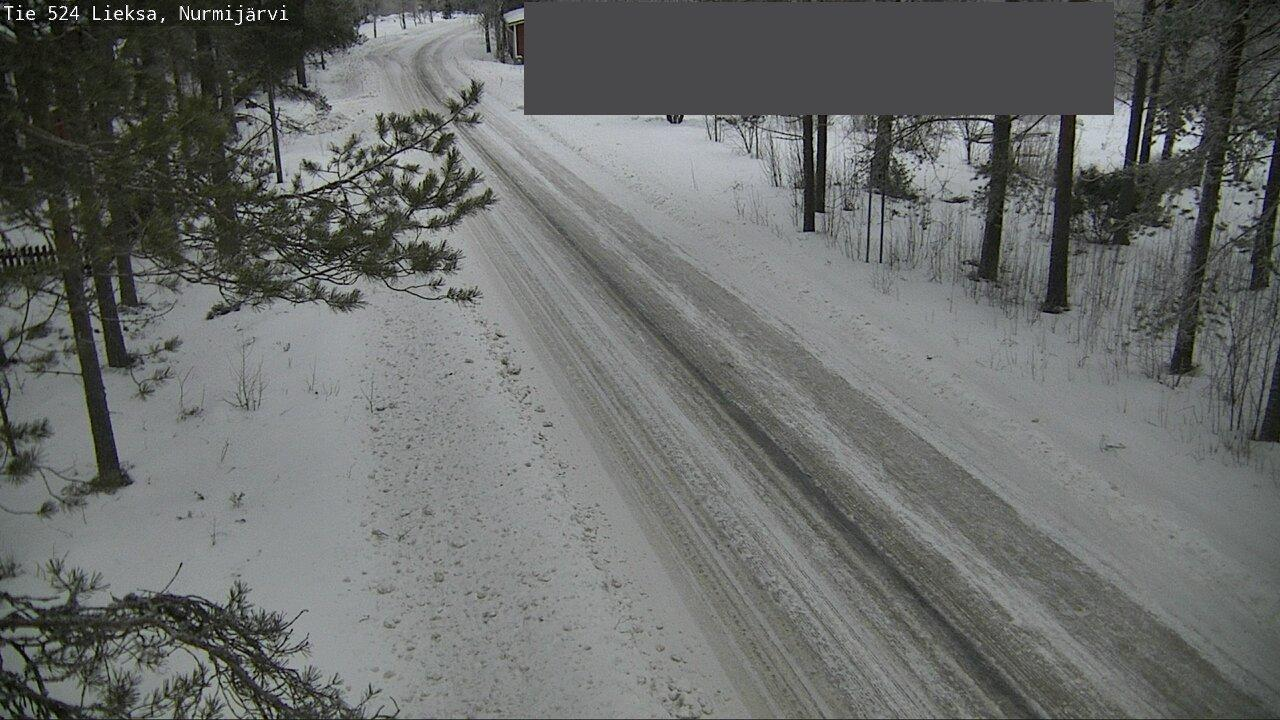

In [12]:
# Display the downloaded image
from IPython.display import Image
Image("/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.02.12_05:39:35_Kuhmoon_C0750101.jpg")

## TRANSCRIPT

In [11]:
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to help the user.
>> User:
What tools can you use?
>> Assistant:
I can use tools for adding and removing API and function tools in the toolbox, within the
"functions" namespace. Here's a summary:  1. **functions.add_api_tools**: This tool is used to add
API tools to the toolbox by specifying the service name, base URL, and optionally, the OpenAPI
Specification URL and destination file.  2. **functions.add_function_tools**: This tool allows
adding function tools by specifying the service name and a list of function names.  3.
**functions.remove_tools**: This tool is used to remove tools from the toolbox by providing the
service name.  4. **multi_tool_use.parallel**: This tool is a wrapper for executing multiple tools
simultaneously in parallel. Only tools within the "functions" namespace can be utilized.  If you
need more specific actions or have a task in mind, please let me know!
>> User:
Add a new API service c